In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.set_visible_devices([gpus[0], gpus[0]], 'GPU')

In [3]:
path = r".\data"

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_dir = Path(path)
images = sorted(list(map(str, data_dir.glob("*.jpg"))))[:]
labels = [os.path.basename(img).split(".jpg")[0] for img in images][:]
characters = sorted(set(char for label in labels for char in label))

print("Unique chars:", characters)

Unique chars: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']




---


**Shuffling:**

In [5]:
N = tf.shape(images)[0]

indices = tf.range(N)

shuffled_indices = tf.random.shuffle(indices)

images = tf.gather(images, shuffled_indices)
labels = tf.gather(labels, shuffled_indices)



---


**Processing photos from their address:**

In [6]:
import numpy as np
import tqdm
img_width = 256
img_height = 64

def preprocess_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels=1) # Decode as grayscale
  img = tf.image.convert_image_dtype(img, tf.float16)
  img = tf.image.resize(img, [img_height, img_width])
  return img


processed_images = [preprocess_image(img_path) for img_path in tqdm.tqdm(images)]

print("Images processed and resized to", img_width, "x", img_height)


100%|███████████████████████████████████████████████████████████████████████████| 13206/13206 [01:08<00:00, 192.09it/s]

Images processed and resized to 256 x 64




---


**Separating training and testing data:**

In [7]:
import numpy as np
labels = [int(l) for l in labels]

# split data
test_split = 0.01
train_split = 1 - test_split

num_samples = len(processed_images)
num_test = int(test_split * num_samples)
num_train = num_samples - num_test

x_train, y_train = processed_images[:num_train], labels[:num_train]
x_test, y_test = processed_images[num_train:], labels[num_train:]

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")


Training samples: 13074
Test samples: 132




---


# **Preparing data for the model:**

We prepare the data here and see an example of it.

In [8]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor([[0]*(8-len(str(j)))+[int(l) for l in list(str(j))] for j in tqdm.tqdm(y_train)])

100%|████████████████████████████████████████████████████████████████████████| 13074/13074 [00:00<00:00, 190883.12it/s]


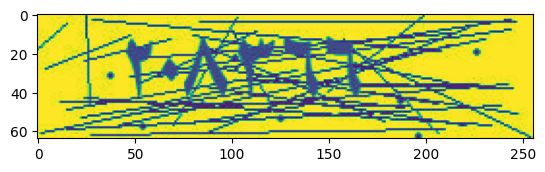

In [9]:
import matplotlib.pyplot as plt
import random
r = random.randint(0, len(x_train)-1)
plt.imshow(np.array(x_train[r]).reshape(64,-1))

In [10]:
y_train[r]

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 0, 2, 0, 8, 3, 6, 6])>

In [11]:
def build_model():
    inp = layers.Input(shape=(img_height, img_width, 1), name="img")
    x = layers.Conv2D(16, 5, activation="relu", padding="same")(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(16, 5, activation="relu", padding="same")(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D((3, 3), strides=3, padding='same')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D((3, 3), strides=3, padding='same')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D((3, 3), strides=3, padding='same')(x)
    x = layers.Reshape((8, -1))(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    out = layers.Dense(len(characters), activation="softmax")(x)
    return keras.Model(inputs=inp, outputs=out)

model = build_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 64, 256, 1)]      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 256, 16)       416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 128, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 128, 32)       4640      
_________________________________________________________________
average_pooling2d (AveragePo (None, 11, 43, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 43, 32)       

In [12]:
checkpoint_path = "./weights/weights-30.weights.h5"
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print(f"Saved weights loaded:{checkpoint_path}")
else:
    print("No weight file exists, training starts with random weights!")

No weight file exists, training starts with random weights!


In [13]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [14]:
checkpoint_path = "weights/weights-{epoch:02d}.weights.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

In [15]:
model.fit(
    x_train,
    y_train,
    validation_split=0.01,
    batch_size=32,
    epochs=40,
    callbacks=[cp_callback]
)

Epoch 1/40
405/405 [==============================] - ETA: 0s - loss: 1.7828 - accuracy: 0.3428
Epoch 00001: saving model to weights\weights-01.weights.h5
405/405 [==============================] - 21s 51ms/step - loss: 1.7828 - accuracy: 0.3428 - val_loss: 1.6818 - val_accuracy: 0.3683
Epoch 2/40
404/405 [============================>.] - ETA: 0s - loss: 1.6747 - accuracy: 0.3703
Epoch 00002: saving model to weights\weights-02.weights.h5
405/405 [==============================] - 18s 45ms/step - loss: 1.6746 - accuracy: 0.3703 - val_loss: 1.6107 - val_accuracy: 0.4027
Epoch 3/40
404/405 [============================>.] - ETA: 0s - loss: 1.5788 - accuracy: 0.4177
Epoch 00003: saving model to weights\weights-03.weights.h5
405/405 [==============================] - 18s 45ms/step - loss: 1.5786 - accuracy: 0.4178 - val_loss: 1.4780 - val_accuracy: 0.4523
Epoch 4/40
405/405 [==============================] - ETA: 0s - loss: 1.4520 - accuracy: 0.4675
Epoch 00004: saving model to weights\wei

In [38]:
def pr(x, y, surplusage=True):
    y = np.array(y).reshape(-1, 1).tolist()
    x = np.array(x).reshape(-1, 64, 256, 1)
    res = model.predict(x).tolist()
    out = []
    score = 0
    for l, a in zip(res, y):
        s = ''.join([str(k.index(max(k))) for k in l])
        if int(s) == a[0]:
            score += 1
        out += [int(s)]
    print('The score:', score/len(y)*100, '%') if surplusage else None
    return out

In [48]:
s = pr(tf.convert_to_tensor(x_test), y_test)

The score: 90.9090909090909 %


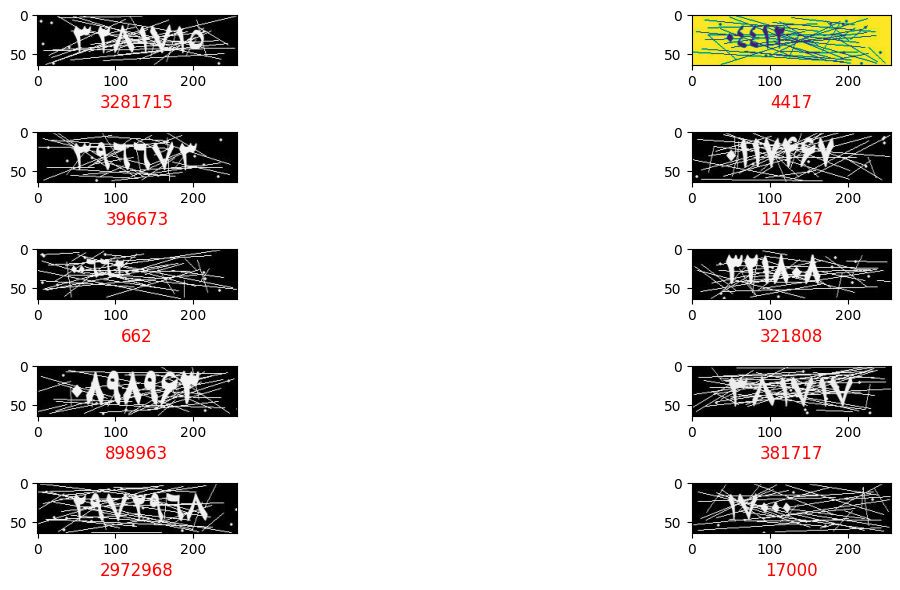

In [70]:
plt.figure(figsize=(15, 6)) 
num_samples = len(x_test)
indices = np.random.choice(num_samples, size=10, replace=False)

x_sample = [x_test[i] for i in indices]
s_sample = [s[i] for i in indices]

for i in range(10):
    ax = plt.subplot(5, 2, i + 1)
    ax.imshow(x_sample[i], cmap='Greys') if (int(s_sample[i])==int(y_test[indices[i]])) else ax.imshow(x_sample[i])
    ax.set_xlabel(str(s_sample[i]), fontsize=12, color='red')

plt.tight_layout()
plt.show()

In [71]:
model.save('captcha.h5')